In [1]:
# some setting to access Google, dont use them if you can access Google

import os
os.environ['HTTP_PROXY'] = 'http://127.0.0.1:58591'
os.environ['HTTPS_PROXY'] = 'http://127.0.0.1:58591'

%matplotlib inline

In [2]:
from osgeo import gdal
import matplotlib.pyplot as plt
import pylandstats as pls
import seaborn as sns

import glob
import re
import os
from xpinyin import Pinyin

import numpy as np
import pandas as pd
from sklearn import metrics

import ee
import geemap

ee.Initialize()

Module C:\Users\Lenovo\.conda\envs\ee_py3\lib\site-packages\pylandstats\landscape.py has not been compiled for Transonic-Numba


### Define basic parameters

In [3]:
# Is the projection for validation or for projecting to the future
Future = True

In [4]:
# import research region
region = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")

# try compare other researuch
region_cities = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")

In [5]:
# set target years
if not Future:
    start_year = '1993_1995'
    base_year = '2005_2007'
    target_year = '2017_2019'
else:
    start_year = '2017_2019'
    future_year = 2030


# define the pixel value that corespondind to the year
true_image_year_val = {f'{year}_{year+2}':(i+1) for (i,year) in enumerate(range(2017,1989,-3))}

# import urban expansion img
urban_expansion_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

# get the true img of base year and target year
if not Future:
    target_img = urban_expansion_img.gte(true_image_year_val[target_year])
    base_img = urban_expansion_img.gte(true_image_year_val[base_year])
else:
    base_img = urban_expansion_img.gte(true_image_year_val[start_year])

In [6]:
# import unet images
if not Future:
    unet_imgs = ! earthengine ls users/wangjinzhulala/GEE_TF/Urban_projection
    unet_imgs = [i for i in unet_imgs if 'hard_' not in i and target_year in i and base_year in i]
    
    # regular expression to find the unet type
    reg_name = re.compile(f'.*prj_{target_year}_(.*)_\d+.*')

    # fetch img data form GEE
    unet_imgs = {f'{reg_name.findall(i)[0]}_{base_year}_{target_year}':ee.ImageCollection(i).mosaic() for i in unet_imgs}
else:
    unet_imgs = {'to_future':ee.ImageCollection("users/wangjinzhulala/GEE_TF/Urban_projection/FCNN_2017_2019_to_future_no_distance_60").mosaic()}

### Plot the loss change when training  UNET

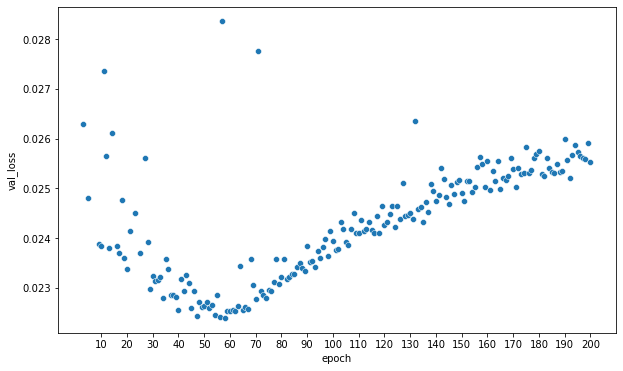

In [7]:
# get the loss metrics
if not Future:
    losses = glob.glob(f'../Data/Training_loss/FCNN_{start_year}_and_{base_year}_prj_{target_year}*') 
    out_path = f"../Data/Training_loss/Train_loss_{start_year}_and_{base_year}_prj_{target_year}.csv"
else:
    losses = glob.glob(f'../Data/Training_loss/FCNN_{start_year}_to_future*')
    out_path = f"../Data/Training_loss/Train_loss_{start_year}_to_future.csv"

# concatenate the dfs
loss_df = pd.concat([pd.read_csv(df) for df in losses])
df_len = loss_df.shape[0]
loss_df['epoch'] = range(1,df_len+1)

# remove outliers to make plot easily recognisible
loss_df_fig = loss_df[loss_df['val_loss']<0.03]

# save loss to csv
loss_df_fig.to_csv(out_path,index=False)
loss_df_fig = pd.read_csv(out_path)

# ploting the loss
plt.figure(figsize=(10,6))
plt.xticks(range(10,df_len+1,10))
sns.scatterplot(data=loss_df_fig,x='epoch',y='val_loss')

### Get the threshold that divide the Unet image into urban/non-urban pixels

In [12]:
# first, segregate the total area into each region
if not Future:
    # get the total urban pixel number of the img in the target year
    target_img_pixel_sum_each_region = target_img.reduceRegions(collection = region_cities,
                                                                reducer = 'sum',
                                                                scale=30).getInfo()
    # turn the stats to df
    target_img_pixel_sum_each_region_df = pd.DataFrame([i['properties'] for i in  target_img_pixel_sum_each_region['features']])
    
else:
    # get the total urban pixel number of the img in the target year
    target_img_pixel_sum_each_region = base_img.reduceRegions(collection = region_cities,
                                                                reducer = 'sum',
                                                                scale=30).getInfo()
    # turn the stats to df
    pred_pix_city = pd.DataFrame([i['properties'] for i in  target_img_pixel_sum_each_region['features']])
    pred_pix_city['area_ratio'] = pred_pix_city['sum']/(pred_pix_city['sum'].sum())
    
    # get the predicted pix_count
    extrapolation_df = pd.read_csv('../Data/Result_csv/fit_ext_tf.csv')
    pred_pix_count = extrapolation_df[extrapolation_df['year'] == future_year]['pix_count'].values[0]

    # segregate pred_pix_count to each city
    target_img_pixel_sum_each_region_df = pred_pix_city[['CityNameC','area_ratio']]
    target_img_pixel_sum_each_region_df['year'] = future_year
    target_img_pixel_sum_each_region_df['sum'] = pred_pix_count*target_img_pixel_sum_each_region_df['area_ratio'] 

<ipython-input-12-e10a3111c21e>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_img_pixel_sum_each_region_df['year'] = future_year
<ipython-input-12-e10a3111c21e>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_img_pixel_sum_each_region_df['sum'] = pred_pix_count*target_img_pixel_sum_each_region_df['area_ratio']


In [14]:
# function to get the threshold
def get_threshold(img,region,target_pixel_sum):    
    # get stats
    stats = img.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                              geometry = region.geometry().bounds(),
                              scale=30,
                              maxPixels = int(1e13))
    
    stats_info = stats.getInfo()
    stats_info = {int(k):[v] for (k,v) in stats_info['b1'].items()}
    
    # compute the threshold
    df = pd.DataFrame(stats_info).T
    df = df.sort_index(ascending=False)
    df.columns = ['unet_val_count']
    df['cum_sum'] = df['unet_val_count'].cumsum()
    df['ratio'] = df['cum_sum']/target_pixel_sum
    df['dist_to_1'] = (df['ratio']-1).abs()
    threshold = df[df['dist_to_1'] == df['dist_to_1'].min()].index.values[0]
    
    # return threshold value
    return threshold,df

##### Recalssify unet_img to hard_reclass image

In [28]:
target_img_pixel_sum_each_region_df

,CityNameC,area_ratio,year,sum
0,宿州市,0.015312,2030.0,3.724937e+06
1,淄博市,0.010601,2030.0,2.578998e+06
2,淮北市,0.004695,2030.0,1.142113e+06
3,淮南市,0.004006,2030.0,9.744463e+05
4,淮安市,0.011450,2030.0,2.785524e+06
...,...,...,...,...
71,泰安市,0.012650,2030.0,3.077480e+06
72,泰州市,0.011741,2030.0,2.856392e+06
73,洛阳市,0.009299,2030.0,2.262200e+06
74,济南市,0.012692,2030.0,3.087647e+06


In [30]:
# get the hard-classification from uner_potential image
unet_img_hard_classified = {}

# loop through each unet_img
for name,img in unet_imgs.items():
    # loop through each city
    for idx,row in target_img_pixel_sum_each_region_df.iterrows():
        
        # get parameters
        city_name = row['CityNameC']
        city_geo = region_cities.filterMetadata('CityNameC','equals',city_name)
        city_urban_pixel_sum = int(row['sum'])
        
        # compute threshold
        threshold,df = get_threshold(img.clip(city_geo),city_geo,city_urban_pixel_sum)
        
        # make the hard classification
        if not Future:
            unet_img_hard_classified[(name,city_name)] = img.gt(int(threshold)).clip(city_geo)
            # report process
            print(f'The threshold of {name}_{city_name}_{base_year}_{target_year} is {threshold}')
        else:
            future_year = row['year']
            unet_img_hard_classified[(name,city_name)] = img.gt(int(threshold)).clip(city_geo)
            # report process
            print(f'The threshold of {name}_{city_name}_{future_year} is {threshold}')
            
# ______________________________put hard-classified unet_img to a df________________________________________
unet_img_hard_classified_df = pd.DataFrame({k:[v] for (k,v) in unet_img_hard_classified.items()}).T
unet_img_hard_classified_df = unet_img_hard_classified_df.reset_index()
unet_img_hard_classified_df.columns = ['type','city','image']

The threshold of to_future_宿州市_2030.0 is 1979
The threshold of to_future_淄博市_2030.0 is 2003
The threshold of to_future_淮北市_2030.0 is 1889
The threshold of to_future_淮南市_2030.0 is 1855
The threshold of to_future_淮安市_2030.0 is 2495
The threshold of to_future_滁州市_2030.0 is 2121
The threshold of to_future_滨州市_2030.0 is 2008
The threshold of to_future_漯河市_2030.0 is 1547
The threshold of to_future_潍坊市_2030.0 is 2671
The threshold of to_future_濮阳市_2030.0 is 2263
The threshold of to_future_烟台市_2030.0 is 2160
The threshold of to_future_焦作市_2030.0 is 2000
The threshold of to_future_盐城市_2030.0 is 3771
The threshold of to_future_石家庄市_2030.0 is 1827
The threshold of to_future_秦皇岛市_2030.0 is 2311
The threshold of to_future_聊城市_2030.0 is 2005
The threshold of to_future_芜湖市_2030.0 is 2521
The threshold of to_future_苏州市_2030.0 is 2207
The threshold of to_future_荷泽市_2030.0 is 2441
The threshold of to_future_莱芜市_2030.0 is 2328
The threshold of to_future_蚌埠市_2030.0 is 1921
The threshold of to_future_衡水市_2

In [16]:
# save and read unet_img_hard_classified_df
if not Future:
    # unet_img_hard_classified_df.to_pickle(f'./Variables/unet_img_hard_classified_df_{base_year}_{target_year}.pkl')
    unet_img_hard_classified_df = pd.read_pickle(f'./Variables/unet_img_hard_classified_df_{base_year}_{target_year}.pkl')
else:
    #unet_img_hard_classified_df.to_pickle(f'./Variables/unet_img_hard_classified_df_{start_year}_to_future.pkl')
    unet_img_hard_classified_df = pd.read_pickle(f'./Variables/unet_img_hard_classified_df_{start_year}_to_future.pkl')

##### Export imgs as seperate city img

In [12]:
#  export img_city to Drive
for idx,row in unet_img_hard_classified_df.iterrows():
    
    # get parameters
    img_type = row['type']
    city_name_cn = row['city']
    city_name_py = Pinyin().get_pinyin(city_name_cn,splitter='_')
    city_img = row['image']
    city_geo = region_cities.filterMetadata('CityNameC','equals',city_name_cn)
    
    # export each of the city image
    task = ee.batch.Export.image.toDrive(image = city_img.clip(city_geo),
                                        description=f'Export {img_type}_{city_name_py}_{base_year}_{target_year}_hard_reclass to Drive',
                                        folder='urban_projection_result_imgs_cities',
                                        fileNamePrefix=f'{img_type}_{city_name_py}_{base_year}_{target_year}_hard_reclass',
                                        region=city_geo.geometry(),
                                        scale=30,
                                        maxPixels=int(1e13),
                                        skipEmptyTiles=True)
    task.start()
    
    # report the process
    print(f'Export {img_type}_{city_name_py}_{base_year}_{target_year}_hard_reclass to Drive')

Export no_distance_su_zhou_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_zi_bo_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_huai_bei_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_huai_nan_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_huai_an_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_chu_zhou_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_bin_zhou_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_ta_he_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_wei_fang_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_pu_yang_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_yan_tai_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_jiao_zuo_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_yan_cheng_shi_2005_2007_2017_2019_hard_reclass to Drive
Export no_distance_shi_jia_zhuang_shi_2005_2007

##### Mosaic the img and then export

In [34]:
# export img to Drive
for img_type in unet_img_hard_classified_df['type'].unique():
    # get imgs and convet them into one mosaiced img
    imgs = unet_img_hard_classified_df[unet_img_hard_classified_df['type']==img_type]['image'].values.tolist()    
    
    if not Future:
        desc = f'{img_type}_{target_year}_hard_reclass to Drive'
        imgs_mosaic = ee.ImageCollection(imgs).mosaic()
    else:
        desc = f'{img_type}_{start_year}_to_future to Drive'
        imgs_mosaic = ee.ImageCollection(imgs).mosaic().toInt8()
    
    # create a task to export the image
    task = ee.batch.Export.image.toDrive(image = imgs_mosaic,
                                        description=f'Export {desc}',
                                        folder='urban_projection_result_imgs',
                                        fileNamePrefix=desc,
                                        region=region.geometry().convexHull(),
                                        scale=30,
                                        maxPixels=int(1e13),
                                        skipEmptyTiles=True)
    task.start()
    
    # report the process
    print(f'Export {desc} to Drive')

Export to_future_2017_2019_to_future to Drive to Drive


### Compute the accuracy metrics| Note, cant get accuracy metrics for a future prediction

In [17]:
unet_img_hard_classified_df

,type,city,image
0,no_distance,宿州市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
1,no_distance,淄博市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
2,no_distance,淮北市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
3,no_distance,淮南市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
4,no_distance,淮安市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...
71,no_distance,泰安市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
72,no_distance,泰州市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
73,no_distance,洛阳市,"ee.Image({\n ""functionInvocationValue"": {\n ..."
74,no_distance,济南市,"ee.Image({\n ""functionInvocationValue"": {\n ..."


In [18]:
def compute_AUC(prob_img,city_geo):
    
    # stack trum img with transition potential img, then mask the stack using base_img.Not()
    true_pred_img = target_img.rename('true').addBands(prob_img.rename('pred')).mask(base_img.Not())
    
    # ramdonly spred 5k points to the city,extrat values and send back to stats
    stats = true_pred_img.sample(region=city_geo,scale=30,numPixels=5000,seed=0).getInfo()
    df = pd.DataFrame([i['properties'] for i in stats['features']])

    fpr, tpr, thresholds = metrics.roc_curve(df['true'], df['pred'])
    auc = metrics.auc(fpr, tpr)
    
    return auc

In [19]:
def compute_Prod_User_Acc(pred_img_city,city_geo):
    
    # get the base img in the given city
    base_img_city = base_img.clip(city_geo)
    
    # sum the pred img with real img, so we can get the transition matrics
    sum_img = pred_img_city.multiply(10).add(target_img).mask(base_img_city.Not())
    
    # get stats from GEE
    hist = sum_img.reduceRegion(reducer = ee.Reducer.frequencyHistogram(),
                      geometry = city_geo.bounds(),
                      scale=30,
                      maxPixels = int(1e13)).getInfo()['b1']
    
    # impute the acc
    producer_acc = hist['11']/(hist['11']+hist['1'])
    user_acc = hist['11']/(hist['11']+hist['10'])    
    
    return producer_acc,user_acc

In [21]:
# function to sum all pixel values
def compute_the_sum(img,geometry):
    count_num = img.reduceRegion(reducer = 'sum',
                      geometry = geometry.bounds(),
                      scale=30,
                      maxPixels = int(1e13)).getInfo()['b1']
    return count_num

# function to compute FoM (Figure of Merit)
def compute_FoM_Hits(unet_img,city_geo):
    
    # get the img in the specific city
    real_img = target_img.clip(city_geo)
    start_img = base_img.clip(city_geo)
    pred_img = unet_img.clip(city_geo) 
    
    # get the change type
    Real_change = real_img.neq(start_img)
    Pred_change = pred_img.neq(start_img)
    
    # get the Stats
    FoM = compute_the_sum(Real_change.And(Pred_change),city_geo)/compute_the_sum(Real_change.Or(Pred_change),city_geo)
    Hits = compute_the_sum(Real_change.And(Pred_change),city_geo)/compute_the_sum(Pred_change,city_geo)
    Change_ratio = compute_the_sum(Real_change,city_geo)/compute_the_sum(base_img,city_geo)
    
    return FoM,Hits,Change_ratio

In [26]:
def compute_Overall_ACC(real_img,pred_img,city_geo):
    
    #________________________Compute the Overall Accuracy_________________________________
    
    total_pixel = compute_the_sum(real_img.updateMask(base_img.Not()).gt(-1).clip(city_geo),city_geo)
    correct_pixel =  compute_the_sum(real_img.updateMask(base_img.Not()).eq(pred_img).clip(city_geo),city_geo)
    
    # compute the overal accuracy
    overall_acc = correct_pixel/total_pixel 
    
    return overall_acc

In [27]:
Acc_dict = {}

for idx,row in unet_img_hard_classified_df.iterrows():
    
    # get parameters
    img_type = row['type']
    city_name_cn = row['city']
    city_name_py = Pinyin().get_pinyin(city_name_cn,splitter='_')
    city_img = row['image']
    city_geo = region_cities.filterMetadata('CityNameC','equals',city_name_cn).geometry()
    
    # get the unet_img
    prob_img = list(unet_imgs.values())[0]
    
    # compute metrics
         
    Overal_acc = compute_Overall_ACC(target_img,city_img,city_geo)
    FoM,Hits,Change_ratio = compute_FoM_Hits(city_img,city_geo)
    AUC = compute_AUC(prob_img,city_geo)
#     Prod_acc,User_acc = compute_Prod_User_Acc(city_img,city_geo)
    
    # save metrics
    Acc_dict[(img_type,city_name_py,'AUC')] = [AUC]
    Acc_dict[(img_type,city_name_py,'FoM')] = [FoM]
    Acc_dict[(img_type,city_name_py,'Change_ratio')] = [Change_ratio]
    Acc_dict[(img_type,city_name_py,'Overal_Acc')] = [Overal_acc]
    Acc_dict[(img_type,city_name_py,'Hits')] = [Hits]
#     Acc_dict[(img_type,city_name_py,'Prod_ACC')] = [Prod_acc]
#     Acc_dict[(img_type,city_name_py,'User_Acc')] = [User_acc]
    
    # report process
    name = f'{city_name_py}_{base_year}_{target_year}'    
    print(f'{name:<35} | AUC:{AUC:.4f} | FoM:{FoM:.4f} | Change_ratio:{Change_ratio:.4f} | Overal_Acc:{Overal_acc:.4f} | Hits:{Hits:.4f}')

su_zhou_shi_2005_2007_2017_2019     | AUC:0.7998 | FoM:0.1953 | Change_ratio:0.1913 | Overal_Acc:0.9047 | Hits:0.3269
zi_bo_shi_2005_2007_2017_2019       | AUC:0.8485 | FoM:0.1803 | Change_ratio:0.2634 | Overal_Acc:0.9023 | Hits:0.3056
huai_bei_shi_2005_2007_2017_2019    | AUC:0.8136 | FoM:0.1929 | Change_ratio:0.2374 | Overal_Acc:0.8932 | Hits:0.3235
huai_nan_shi_2005_2007_2017_2019    | AUC:0.7752 | FoM:0.1605 | Change_ratio:0.3097 | Overal_Acc:0.8850 | Hits:0.2766
huai_an_shi_2005_2007_2017_2019     | AUC:0.8403 | FoM:0.2337 | Change_ratio:0.5733 | Overal_Acc:0.9110 | Hits:0.3790
chu_zhou_shi_2005_2007_2017_2019    | AUC:0.7621 | FoM:0.1822 | Change_ratio:0.3461 | Overal_Acc:0.9059 | Hits:0.3084
bin_zhou_shi_2005_2007_2017_2019    | AUC:0.7759 | FoM:0.1666 | Change_ratio:0.2402 | Overal_Acc:0.9150 | Hits:0.2857
ta_he_shi_2005_2007_2017_2019       | AUC:0.8380 | FoM:0.2152 | Change_ratio:0.2424 | Overal_Acc:0.9273 | Hits:0.3542
wei_fang_shi_2005_2007_2017_2019    | AUC:0.7834 | FoM:0

cang_zhou_shi_2005_2007_2017_2019   | AUC:0.7910 | FoM:0.1619 | Change_ratio:0.2181 | Overal_Acc:0.9315 | Hits:0.2788
tai_an_shi_2005_2007_2017_2019      | AUC:0.7963 | FoM:0.1839 | Change_ratio:0.3401 | Overal_Acc:0.8949 | Hits:0.3107
tai_zhou_shi_2005_2007_2017_2019    | AUC:0.7790 | FoM:0.2623 | Change_ratio:0.6139 | Overal_Acc:0.8316 | Hits:0.4157
luo_yang_shi_2005_2007_2017_2019    | AUC:0.9108 | FoM:0.2089 | Change_ratio:0.4816 | Overal_Acc:0.9588 | Hits:0.3456
ji_nan_shi_2005_2007_2017_2019      | AUC:0.8088 | FoM:0.1518 | Change_ratio:0.1513 | Overal_Acc:0.9211 | Hits:0.2637
ji_ning_shi_2005_2007_2017_2019     | AUC:0.7991 | FoM:0.1697 | Change_ratio:0.1881 | Overal_Acc:0.9073 | Hits:0.2902


In [28]:
# save acc to disk
Acc_df = pd.DataFrame(Acc_dict).T
Acc_df = Acc_df.reset_index()
Acc_df.columns = ['img_type','city','Acc_type','val']
Acc_df['year'] = target_year

In [29]:
Acc_df_pivot = Acc_df.pivot_table(index=['img_type','city'],columns=['Acc_type'],values=['val','year']).reset_index()
Acc_df_pivot.columns = ['img_type','city','AUC','Change_ratio','FoM','Hits','Overal_Acc']
Acc_df_pivot.to_csv(f'./Variables/Acc_df_{base_year}_{target_year}.csv',index=False)

<AxesSubplot:xlabel='Change_ratio', ylabel='FoM'>

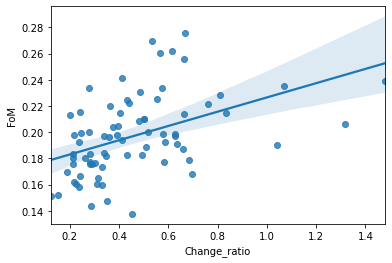

In [30]:
sns.regplot(data=Acc_df_pivot,x='Change_ratio',y='FoM')

<AxesSubplot:xlabel='Change_ratio', ylabel='AUC'>

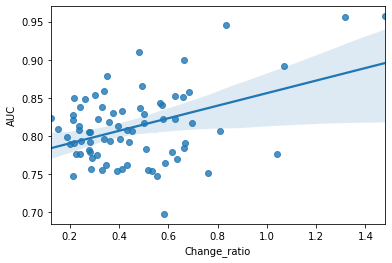

In [31]:
sns.regplot(data=Acc_df_pivot,x='Change_ratio',y='AUC')